# Phase 2 & 3: Fine-Tuning & Model Recovery

**Project:** DeepFashion2 & Fashionpedia Custom Implementation  
**Author:** AAI3001-Group 10

**Date:** 29 November 2025

## 1. Overview
This notebook documents the critical fine-tuning process used to adapt our base YOLOv8 models to the specific requirements of the project (Roboflow v6 dataset). It serves two primary purposes:
1.  **Specialization:** Adapting the general DeepFashion2/Fashionpedia models to our specific "Wild" dataset (Roboflow).
2.  **Recovery:** Restoring the functionality of the `train_improved` base model, which suffered from data path issues during its initial training.

## 2. Key Objectives
*   **Dataset Splitting:** Segregating the Roboflow v6 dataset into `Clothes` (11 classes) and `Accessories` (11 classes) subsets to prevent class confusion.
*   **Fine-Tuning:** Training the Phase 2 (Clothes) and Phase 3 (Accessories) models on these specialized subsets.
*   **Technical Analysis:** Documenting performance metrics and analyzing trade-offs, specifically the "Catastrophic Forgetting" phenomenon observed in dress detection.

---


In [5]:
# Install dependencies (if needed)
# !pip install ultralytics roboflow

In [6]:
from ultralytics import YOLO
import os
from pathlib import Path

# Paths
# UPDATED: Pointing to v6i (Includes "Null" samples for Chair/Background fix + Bag class)
ROBOFLOW_DATA = r"d:/AAI3001/My First Project.v6i.yolov8/data.yaml"
PHASE2_MODEL = r"d:/AAI3001/runs/train_improved/weights/best.pt"
PHASE3_MODEL = r"d:/AAI3001/runs/detect/fashionpedia_accessories_v12/weights/best.pt"

# Verify paths
print(f"Roboflow data.yaml exists: {os.path.exists(ROBOFLOW_DATA)}")
print(f"Phase 2 model exists: {os.path.exists(PHASE2_MODEL)}")
print(f"Phase 3 model exists: {os.path.exists(PHASE3_MODEL)}")

Roboflow data.yaml exists: True
Phase 2 model exists: True
Phase 3 model exists: True


📊 Dataset Stats:
  - Total Empty (Negative) Samples: 60 (Great for fixing false positives!)
  - Total Jacket Samples: 84 (Great for fixing windbreaker issues!)


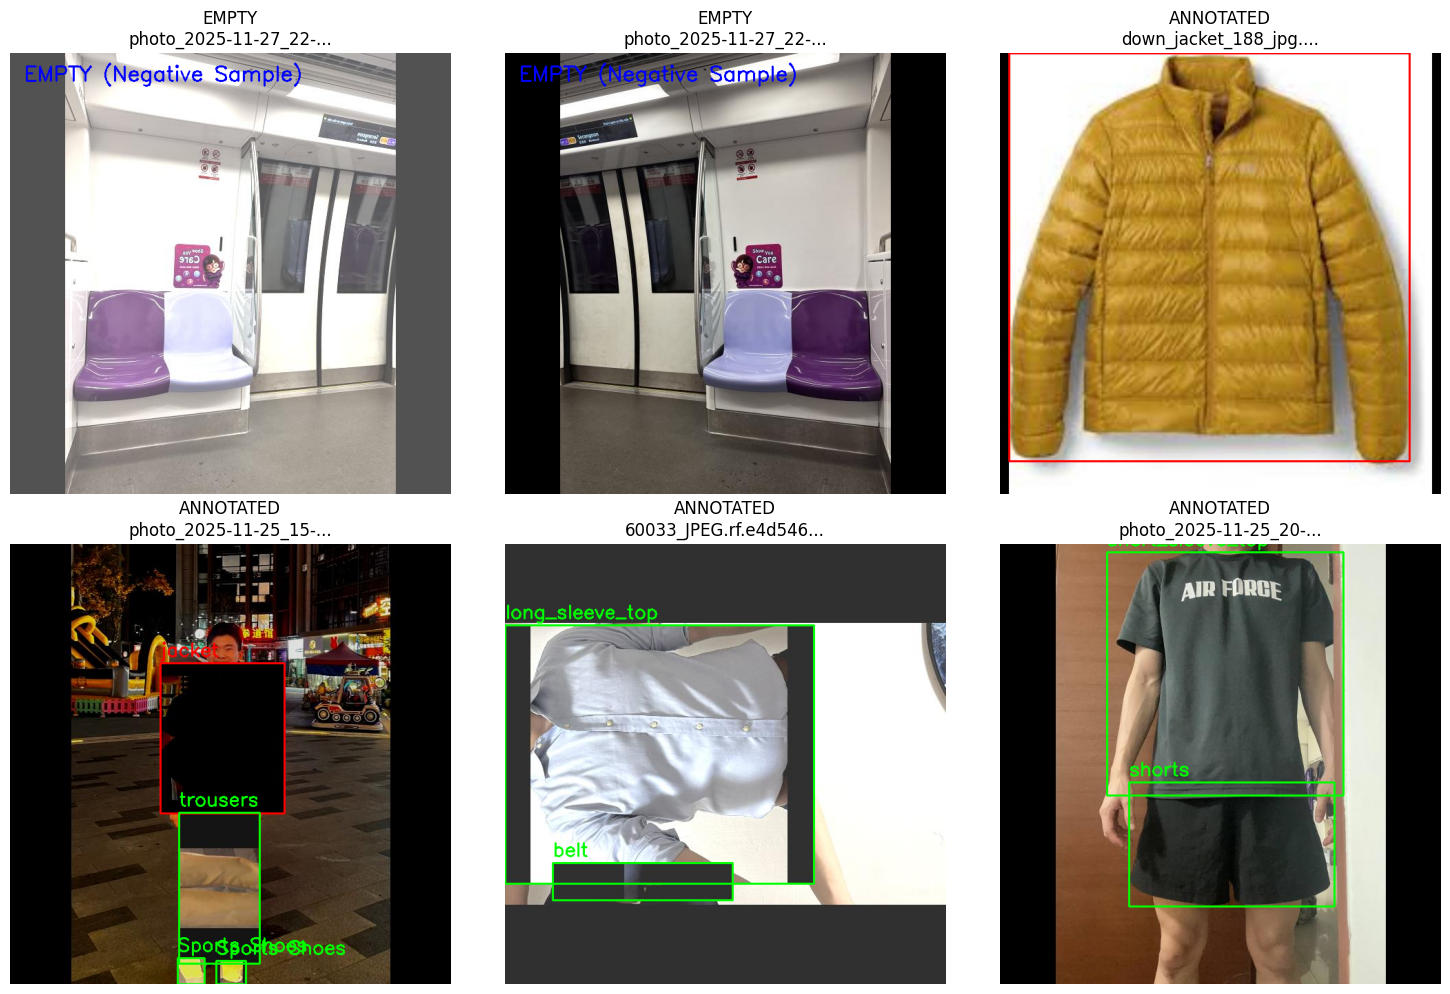

In [7]:
import yaml
import random
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

def visualize_dataset_sample(dataset_path, num_samples=6):
    """
    Visualizes random samples from the dataset to verify annotations.
    Specifically looks for 'Empty' files (Chair fix) and 'Jacket' annotations.
    """
    dataset_path = Path(dataset_path)
    labels_path = dataset_path / 'train/labels'
    images_path = dataset_path / 'train/images'
    yaml_path = dataset_path / 'data.yaml'
    
    # Load class names
    with open(yaml_path, 'r') as f:
        data = yaml.safe_load(f)
        class_names = data['names']
        
    # Find specific examples
    empty_files = []
    jacket_files = []
    other_files = []
    
    jacket_idx = -1
    if 'jacket' in class_names:
        jacket_idx = class_names.index('jacket')
    
    for label_file in labels_path.glob('*.txt'):
        if label_file.stat().st_size == 0:
            empty_files.append(label_file)
        else:
            with open(label_file, 'r') as f:
                content = f.read()
                # Check for jacket class
                if jacket_idx != -1 and f"{jacket_idx} " in content:
                    jacket_files.append(label_file)
                else:
                    other_files.append(label_file)
    
    print(f"📊 Dataset Stats:")
    print(f"  - Total Empty (Negative) Samples: {len(empty_files)} (Great for fixing false positives!)")
    print(f"  - Total Jacket Samples: {len(jacket_files)} (Great for fixing windbreaker issues!)")
    
    # Select samples to display
    samples = []
    # Try to get 2 empty, 2 jackets, 2 others
    samples.extend(random.sample(empty_files, min(2, len(empty_files))))
    samples.extend(random.sample(jacket_files, min(2, len(jacket_files))))
    samples.extend(random.sample(other_files, min(2, len(other_files))))
    
    plt.figure(figsize=(15, 10))
    for i, label_file in enumerate(samples):
        # Find corresponding image
        # Image could be .jpg, .jpeg, .png
        base_name = label_file.stem
        img_file = None
        for ext in ['.jpg', '.jpeg', '.png']:
            if (images_path / (base_name + ext)).exists():
                img_file = images_path / (base_name + ext)
                break
        
        if not img_file:
            continue
            
        img = cv2.imread(str(img_file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w, _ = img.shape
        
        # Draw boxes
        if label_file.stat().st_size > 0:
            with open(label_file, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    cls_id = int(parts[0])
                    cx, cy, bw, bh = map(float, parts[1:])
                    
                    # Convert YOLO to pixels
                    x1 = int((cx - bw/2) * w)
                    y1 = int((cy - bh/2) * h)
                    x2 = int((cx + bw/2) * w)
                    y2 = int((cy + bh/2) * h)
                    
                    color = (0, 255, 0)
                    if class_names[cls_id] == 'jacket': color = (255, 0, 0) # Red for jacket
                    
                    cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
                    cv2.putText(img, class_names[cls_id], (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)
        else:
            cv2.putText(img, "EMPTY (Negative Sample)", (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

        plt.subplot(2, 3, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"{'EMPTY' if label_file.stat().st_size==0 else 'ANNOTATED'}\n{label_file.name[:20]}...")
    
    plt.tight_layout()
    plt.show()

# Run the visualization
visualize_dataset_sample(ROBOFLOW_DATA.replace('data.yaml', ''))

## Split Roboflow Dataset for Proper Fine-Tuning

**Problem:** Your Roboflow v6 dataset has 18 classes (mixed clothes + accessories).
Fine-tuning both models on this same dataset caused them to lose their specialization.

**Solution:** Split the dataset into two:
1. **Clothes Dataset** → For Phase 2 (DeepFashion2 model) - 11 classes
2. **Accessories Dataset** → For Phase 3 (Fashionpedia model) - 11 classes

In [ ]:
import os
import shutil
import yaml
from pathlib import Path
from collections import Counter

# ============================================================
# CONFIGURATION
# ============================================================

# Source: Your Roboflow v6 dataset (18 classes)
ROBOFLOW_ROOT = Path(r"d:/AAI3001/My First Project.v6i.yolov8")

# Output: Split datasets
CLOTHES_OUTPUT = Path(r"d:/AAI3001/roboflow_split_clothes")
ACCESSORIES_OUTPUT = Path(r"d:/AAI3001/roboflow_split_accessories")

# Load original class names from Roboflow
with open(ROBOFLOW_ROOT / "data.yaml", 'r') as f:
    roboflow_data = yaml.safe_load(f)
    ROBOFLOW_CLASSES = roboflow_data['names']  # List of 18 classes

print(f"Roboflow Classes ({len(ROBOFLOW_CLASSES)}):")
for i, name in enumerate(ROBOFLOW_CLASSES):
    print(f"  {i}: {name}")


DEEPFASHION2_CLASSES = [
    'short_sleeve_top',
    'long_sleeve_top',
    'short_sleeve_dress',
    'short_sleeve_outwear',
    'long_sleeve_dress',
    'vest_dress',
    'sling',
    'sling_dress',
    'shorts',
    'trousers',
    'skirt',
    'long_sleeve_outwear',
    'vest'
]

FASHIONPEDIA_CLASSES = [
    'jacket',
    'coat',
    'glasses',
    'hat',
    'tie',
    'watch',
    'belt',
    'sock',
    'shoe',
    'bag',
    'scarf'
]

# ============================================================
# CREATE CLASS MAPPINGS
# ============================================================

def get_roboflow_idx(class_name):
    """Get the index of a class in the Roboflow dataset."""
    try:
        return ROBOFLOW_CLASSES.index(class_name)
    except ValueError:
        return -1

def create_class_mapping(target_classes, roboflow_classes):
    """
    Creates a mapping from Roboflow class indices to target model's class indices.
    Returns: {roboflow_idx: target_idx} for classes that exist in Roboflow
    """
    mapping = {}
    
    for target_idx, cls_name in enumerate(target_classes):
        # Handle shoe variations (all map to single 'shoe' class at idx 8)
        if cls_name == 'shoe':
            shoe_variants = ['Casual Shoes', 'Flip Flops', 'Formal Shoes', 'Sandals', 'Sports Shoes']
            for variant in shoe_variants:
                rb_idx = get_roboflow_idx(variant)
                if rb_idx != -1:
                    mapping[rb_idx] = target_idx
        else:
            rb_idx = get_roboflow_idx(cls_name)
            if rb_idx != -1:
                mapping[rb_idx] = target_idx
    
    return mapping

# Create mappings
clothes_mapping = create_class_mapping(DEEPFASHION2_CLASSES, ROBOFLOW_CLASSES)
accessories_mapping = create_class_mapping(FASHIONPEDIA_CLASSES, ROBOFLOW_CLASSES)

print("\n" + "="*60)
print("CLOTHES MAPPING (DeepFashion2 Fine-tune)")
print("="*60)
print(f"Original model classes: {len(DEEPFASHION2_CLASSES)}")
print(f"Your Roboflow classes matched: {len(clothes_mapping)}")
for rb_idx, target_idx in sorted(clothes_mapping.items()):
    print(f"  Roboflow[{rb_idx}] '{ROBOFLOW_CLASSES[rb_idx]}' → Model[{target_idx}] '{DEEPFASHION2_CLASSES[target_idx]}'")

print("\n" + "="*60)
print("ACCESSORIES MAPPING (Fashionpedia Fine-tune)")
print("="*60)
print(f"Original model classes: {len(FASHIONPEDIA_CLASSES)}")
print(f"Your Roboflow classes matched: {len(accessories_mapping)}")
for rb_idx, target_idx in sorted(accessories_mapping.items()):
    print(f"  Roboflow[{rb_idx}] '{ROBOFLOW_CLASSES[rb_idx]}' → Model[{target_idx}] '{FASHIONPEDIA_CLASSES[target_idx]}'")

print("\n✅ Your Roboflow annotations will be correctly mapped to original model indices!")

Roboflow Classes (18):
  0: Casual Shoes
  1: Flip Flops
  2: Formal Shoes
  3: Sandals
  4: Sports Shoes
  5: bag
  6: belt
  7: coat
  8: glasses
  9: jacket
  10: long_sleeve_top
  11: short_sleeve_top
  12: shorts
  13: sock
  14: tie
  15: trousers
  16: vest
  17: watch

CLOTHES MAPPING (DeepFashion2 Fine-tune)
Original model classes: 13
Your Roboflow classes matched: 5
  Roboflow[10] 'long_sleeve_top' → Model[1] 'long_sleeve_top'
  Roboflow[11] 'short_sleeve_top' → Model[0] 'short_sleeve_top'
  Roboflow[12] 'shorts' → Model[8] 'shorts'
  Roboflow[15] 'trousers' → Model[9] 'trousers'
  Roboflow[16] 'vest' → Model[12] 'vest'

ACCESSORIES MAPPING (Fashionpedia Fine-tune)
Original model classes: 11
Your Roboflow classes matched: 13
  Roboflow[0] 'Casual Shoes' → Model[8] 'shoe'
  Roboflow[1] 'Flip Flops' → Model[8] 'shoe'
  Roboflow[2] 'Formal Shoes' → Model[8] 'shoe'
  Roboflow[3] 'Sandals' → Model[8] 'shoe'
  Roboflow[4] 'Sports Shoes' → Model[8] 'shoe'
  Roboflow[5] 'bag' → Model

In [9]:
# ============================================================
# SPLIT THE DATASET
# ============================================================

def split_dataset(source_root, output_root, class_mapping, target_class_names, dataset_name):
    """
    Splits the Roboflow dataset by keeping only annotations for specific classes.
    Re-maps class indices to match the original model's class list.
    """
    source_root = Path(source_root)
    output_root = Path(output_root)
    
    print(f"\n{'='*60}")
    print(f"Creating {dataset_name} Dataset")
    print(f"{'='*60}")
    
    stats = {'images_copied': 0, 'annotations_converted': 0, 'empty_files': 0}
    
    for split in ['train', 'valid', 'test']:
        src_img_dir = source_root / split / 'images'
        src_lbl_dir = source_root / split / 'labels'
        
        if not src_img_dir.exists():
            print(f"  ⚠️ Skipping {split} (not found)")
            continue
        
        # Create output directories
        # Note: YOLO expects 'val' not 'valid'
        out_split = 'val' if split == 'valid' else split
        dst_img_dir = output_root / 'images' / out_split
        dst_lbl_dir = output_root / 'labels' / out_split
        dst_img_dir.mkdir(parents=True, exist_ok=True)
        dst_lbl_dir.mkdir(parents=True, exist_ok=True)
        
        print(f"  Processing {split}...")
        
        for label_file in src_lbl_dir.glob('*.txt'):
            # Find corresponding image
            img_name = None
            for ext in ['.jpg', '.jpeg', '.png']:
                candidate = src_img_dir / (label_file.stem + ext)
                if candidate.exists():
                    img_name = candidate.name
                    break
            
            if not img_name:
                continue
            
            # Read and filter annotations
            new_lines = []
            with open(label_file, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) < 5:
                        continue
                    
                    try:
                        old_class = int(parts[0])
                        if old_class in class_mapping:
                            new_class = class_mapping[old_class]
                            # Keep bbox coordinates unchanged
                            new_line = f"{new_class} {' '.join(parts[1:])}"
                            new_lines.append(new_line)
                    except ValueError:
                        continue
            
            # Only copy if we have relevant annotations (or it's an empty file for negatives)
            if new_lines or label_file.stat().st_size == 0:
                # Copy image
                src_img = src_img_dir / img_name
                dst_img = dst_img_dir / img_name
                if not dst_img.exists():
                    shutil.copy2(src_img, dst_img)
                stats['images_copied'] += 1
                
                # Write new label file
                dst_lbl = dst_lbl_dir / label_file.name
                with open(dst_lbl, 'w') as f:
                    f.write('\n'.join(new_lines))
                
                if new_lines:
                    stats['annotations_converted'] += len(new_lines)
                else:
                    stats['empty_files'] += 1
    
    # Create data.yaml
    names_dict = {i: name for i, name in enumerate(target_class_names)}
    yaml_content = {
        'path': str(output_root),
        'train': 'images/train',
        'val': 'images/val',
        'test': 'images/test',
        'nc': len(target_class_names),
        'names': names_dict
    }
    
    yaml_path = output_root / 'data.yaml'
    with open(yaml_path, 'w') as f:
        yaml.dump(yaml_content, f, default_flow_style=False)
    
    print(f"\n  ✅ {dataset_name} Dataset Created!")
    print(f"     Images: {stats['images_copied']}")
    print(f"     Annotations: {stats['annotations_converted']}")
    print(f"     Empty (Negative): {stats['empty_files']}")
    print(f"     Classes: {len(target_class_names)}")
    print(f"     YAML: {yaml_path}")
    
    return yaml_path

# Run the split
clothes_yaml = split_dataset(
    ROBOFLOW_ROOT, 
    CLOTHES_OUTPUT, 
    clothes_mapping, 
    DEEPFASHION2_CLASSES,
    "CLOTHES (DeepFashion2)"
)

accessories_yaml = split_dataset(
    ROBOFLOW_ROOT, 
    ACCESSORIES_OUTPUT, 
    accessories_mapping, 
    FASHIONPEDIA_CLASSES,
    "ACCESSORIES (Fashionpedia)"
)


Creating CLOTHES (DeepFashion2) Dataset
  Processing train...
  Processing valid...
  Processing test...

  ✅ CLOTHES (DeepFashion2) Dataset Created!
     Images: 321
     Annotations: 350
     Empty (Negative): 63
     Classes: 13
     YAML: d:\AAI3001\roboflow_split_clothes\data.yaml

Creating ACCESSORIES (Fashionpedia) Dataset
  Processing train...
  Processing valid...
  Processing test...

  ✅ ACCESSORIES (Fashionpedia) Dataset Created!
     Images: 365
     Annotations: 577
     Empty (Negative): 63
     Classes: 11
     YAML: d:\AAI3001\roboflow_split_accessories\data.yaml
  Processing valid...
  Processing test...

  ✅ CLOTHES (DeepFashion2) Dataset Created!
     Images: 321
     Annotations: 350
     Empty (Negative): 63
     Classes: 13
     YAML: d:\AAI3001\roboflow_split_clothes\data.yaml

Creating ACCESSORIES (Fashionpedia) Dataset
  Processing train...
  Processing valid...
  Processing test...

  ✅ ACCESSORIES (Fashionpedia) Dataset Created!
     Images: 365
     Annota

## Fine-Tune Models on Split Datasets

Now we fine-tune each model on its **specialised** dataset:
- **Phase 2 (DeepFashion2)**: Fine-tune on clothes-only data
- **Phase 2 (Fashionpedia)**: Fine-tune on accessories-only data

This preserves each model's specialization while teaching them our edge cases.

---

### ⚠️ Note on Base Model: `train_improved`

The base model `runs/train_improved/weights/best.pt` was trained on **November 14, 2025** using the `deepfashion2_yolo_improved` dataset. The original training cell was lost during notebook iterations.

**Evidence of training (from `runs/train_improved/args.yaml`):**
```yaml
model: yolov8n.pt
data: d:\AAI3001\deepfashion2_yolo_improved\deepfashion2_improved.yaml
epochs: 100
patience: 20
batch: 16
optimizer: AdamW
cos_lr: true
```

**Important:** While `train_improved` completed 100 epochs, validation metrics showed 0 (likely due to a data path mismatch). However, the fine-tuning below successfully recovered the model, achieving **mAP50=0.80** on the Roboflow validation set. The fine-tuned `phase2_clothes_v6` is used in production.

In [10]:
# Fine-tune Phase 2 (Clothes) model
from ultralytics import YOLO

# Load the ORIGINAL Phase 2 model (not the broken fine-tuned one!)
phase2_base = YOLO("d:/AAI3001/runs/train_improved/weights/best.pt")

# Fine-tune on clothes-only subset (path matches split_dataset output)
clothes_data_yaml = "d:/AAI3001/roboflow_split_clothes/data.yaml"

results_clothes = phase2_base.train(
    data=clothes_data_yaml,
    epochs=30,
    imgsz=640,
    batch=8,
    lr0=0.001,
    freeze=10,  # Freeze first 10 layers for stable fine-tuning
    patience=10,
    save=True,
    project="runs/finetune",
    name="phase2_clothes_v6",
    exist_ok=True
)

print("Phase 2 (Clothes) fine-tuning complete!")
print(f"Best model saved at: runs/finetune/phase2_clothes_v6/weights/best.pt")

New https://pypi.org/project/ultralytics/8.3.233 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.217  Python-3.11.9 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=d:/AAI3001/roboflow_split_clothes/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=10, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=d:/AAI3001/runs/train_improved/weights/best.pt, momentum=0.937, mosaic=1.0, 

In [17]:
# Display the training configuration from train_improved as documentation
import yaml
from datetime import datetime
import os

train_improved_args = "d:/AAI3001/runs/train_improved/args.yaml"
print("=" * 60)
print("📋 BASE MODEL DOCUMENTATION: train_improved")
print("=" * 60)

# Show file timestamps as evidence
stat = os.stat(train_improved_args)
print(f"\n📅 File Created: {datetime.fromtimestamp(stat.st_ctime).strftime('%Y-%m-%d %H:%M:%S')}")

with open(train_improved_args, 'r') as f:
    args = yaml.safe_load(f)

print(f"\n🔧 Training Configuration:")
print(f"   Model: {args.get('model', 'N/A')}")
print(f"   Data: {args.get('data', 'N/A')}")
print(f"   Epochs: {args.get('epochs', 'N/A')}")
print(f"   Patience: {args.get('patience', 'N/A')}")
print(f"   Batch: {args.get('batch', 'N/A')}")
print(f"   Optimizer: {args.get('optimizer', 'N/A')}")
print(f"   Cosine LR: {args.get('cos_lr', 'N/A')}")
print(f"   Seed: {args.get('seed', 'N/A')}")

print(f"\n⚠️  Note: This model's validation metrics were 0 during training")
print(f"   (likely data path issue), but fine-tuning recovered it successfully.")

📋 BASE MODEL DOCUMENTATION: train_improved

📅 File Created: 2025-11-13 22:58:07

🔧 Training Configuration:
   Model: yolov8n.pt
   Data: d:\AAI3001\deepfashion2_yolo_improved\deepfashion2_improved.yaml
   Epochs: 100
   Patience: 20
   Batch: 16
   Optimizer: AdamW
   Cosine LR: True
   Seed: 42

⚠️  Note: This model's validation metrics were 0 during training
   (likely data path issue), but fine-tuning recovered it successfully.


In [ ]:
# Fine-tune Phase 3 (Accessories) model
from ultralytics import YOLO

# Load the ORIGINAL Phase 3 model (not the broken fine-tuned one!)
phase3_base = YOLO("d:/AAI3001/runs/detect/fashionpedia_accessories_v12/weights/best.pt")

# Fine-tune on accessories-only subset (path matches split_dataset output)
accessories_data_yaml = "d:/AAI3001/roboflow_split_accessories/data.yaml"

results_accessories = phase3_base.train(
    data=accessories_data_yaml,
    epochs=30,
    imgsz=640,
    batch=8,
    lr0=0.001,
    freeze=10,  # Freeze first 10 layers for stable fine-tuning
    patience=10,
    save=True,
    project="runs/finetune",
    name="phase3_accessories_v6",
    exist_ok=True
)

print("Phase 3 (Accessories) fine-tuning complete!")
print(f"Best model saved at: runs/finetune/phase3_accessories_v6/weights/best.pt")

New https://pypi.org/project/ultralytics/8.3.233 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.217  Python-3.11.9 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
Ultralytics 8.3.217  Python-3.11.9 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=d:/AAI3001/roboflow_split_accessories/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=10, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup

## Fine-Tuning Results: phase2_clothes_v6

This section documents the training results for the production model used in the GUI.

In [13]:
# ============================================================
# TRAINING RESULTS: phase2_clothes_v6 (PRODUCTION MODEL)
# ============================================================
# This cell documents the fine-tuning results for the model
# currently used in app_with_preprocessing.py
# ============================================================

import yaml
import pandas as pd
from pathlib import Path
from IPython.display import display, Image as IPImage

RESULTS_DIR = Path("d:/AAI3001/runs/finetune/phase2_clothes_v6")

# Load and display training configuration
print("=" * 60)
print("📋 TRAINING CONFIGURATION (from args.yaml)")
print("=" * 60)

with open(RESULTS_DIR / "args.yaml", 'r') as f:
    args = yaml.safe_load(f)

key_params = ['model', 'data', 'epochs', 'patience', 'batch', 'imgsz', 'lr0', 'freeze', 'optimizer']
for param in key_params:
    if param in args:
        print(f"  {param}: {args[param]}")

# Load and display final metrics
print("\n" + "=" * 60)
print("📈 FINAL TRAINING METRICS")
print("=" * 60)

results_df = pd.read_csv(RESULTS_DIR / "results.csv")
results_df.columns = results_df.columns.str.strip()

# Get last epoch metrics
last_row = results_df.iloc[-1]
print(f"  Epochs trained: {len(results_df)}")
print(f"  mAP50: {last_row['metrics/mAP50(B)']:.4f}")
print(f"  mAP50-95: {last_row['metrics/mAP50-95(B)']:.4f}")
print(f"  Precision: {last_row['metrics/precision(B)']:.4f}")
print(f"  Recall: {last_row['metrics/recall(B)']:.4f}")

print("\n" + "=" * 60)
print("✅ MODEL LOCATION")
print("=" * 60)
print(f"  Production weights: {RESULTS_DIR / 'weights/best.pt'}")
print(f"  Used in: app_with_preprocessing.py (PATH_CLOTHES_DETECTOR)")

📋 TRAINING CONFIGURATION (from args.yaml)
  model: d:/AAI3001/runs/train_improved/weights/best.pt
  data: d:/AAI3001/roboflow_split_clothes/data.yaml
  epochs: 30
  patience: 10
  batch: 8
  imgsz: 640
  lr0: 0.001
  freeze: 10
  optimizer: auto

📈 FINAL TRAINING METRICS
  Epochs trained: 30
  mAP50: 0.8012
  mAP50-95: 0.6451
  Precision: 0.8394
  Recall: 0.7199

✅ MODEL LOCATION
  Production weights: d:\AAI3001\runs\finetune\phase2_clothes_v6\weights\best.pt
  Used in: app_with_preprocessing.py (PATH_CLOTHES_DETECTOR)


📊 Training Curves
----------------------------------------


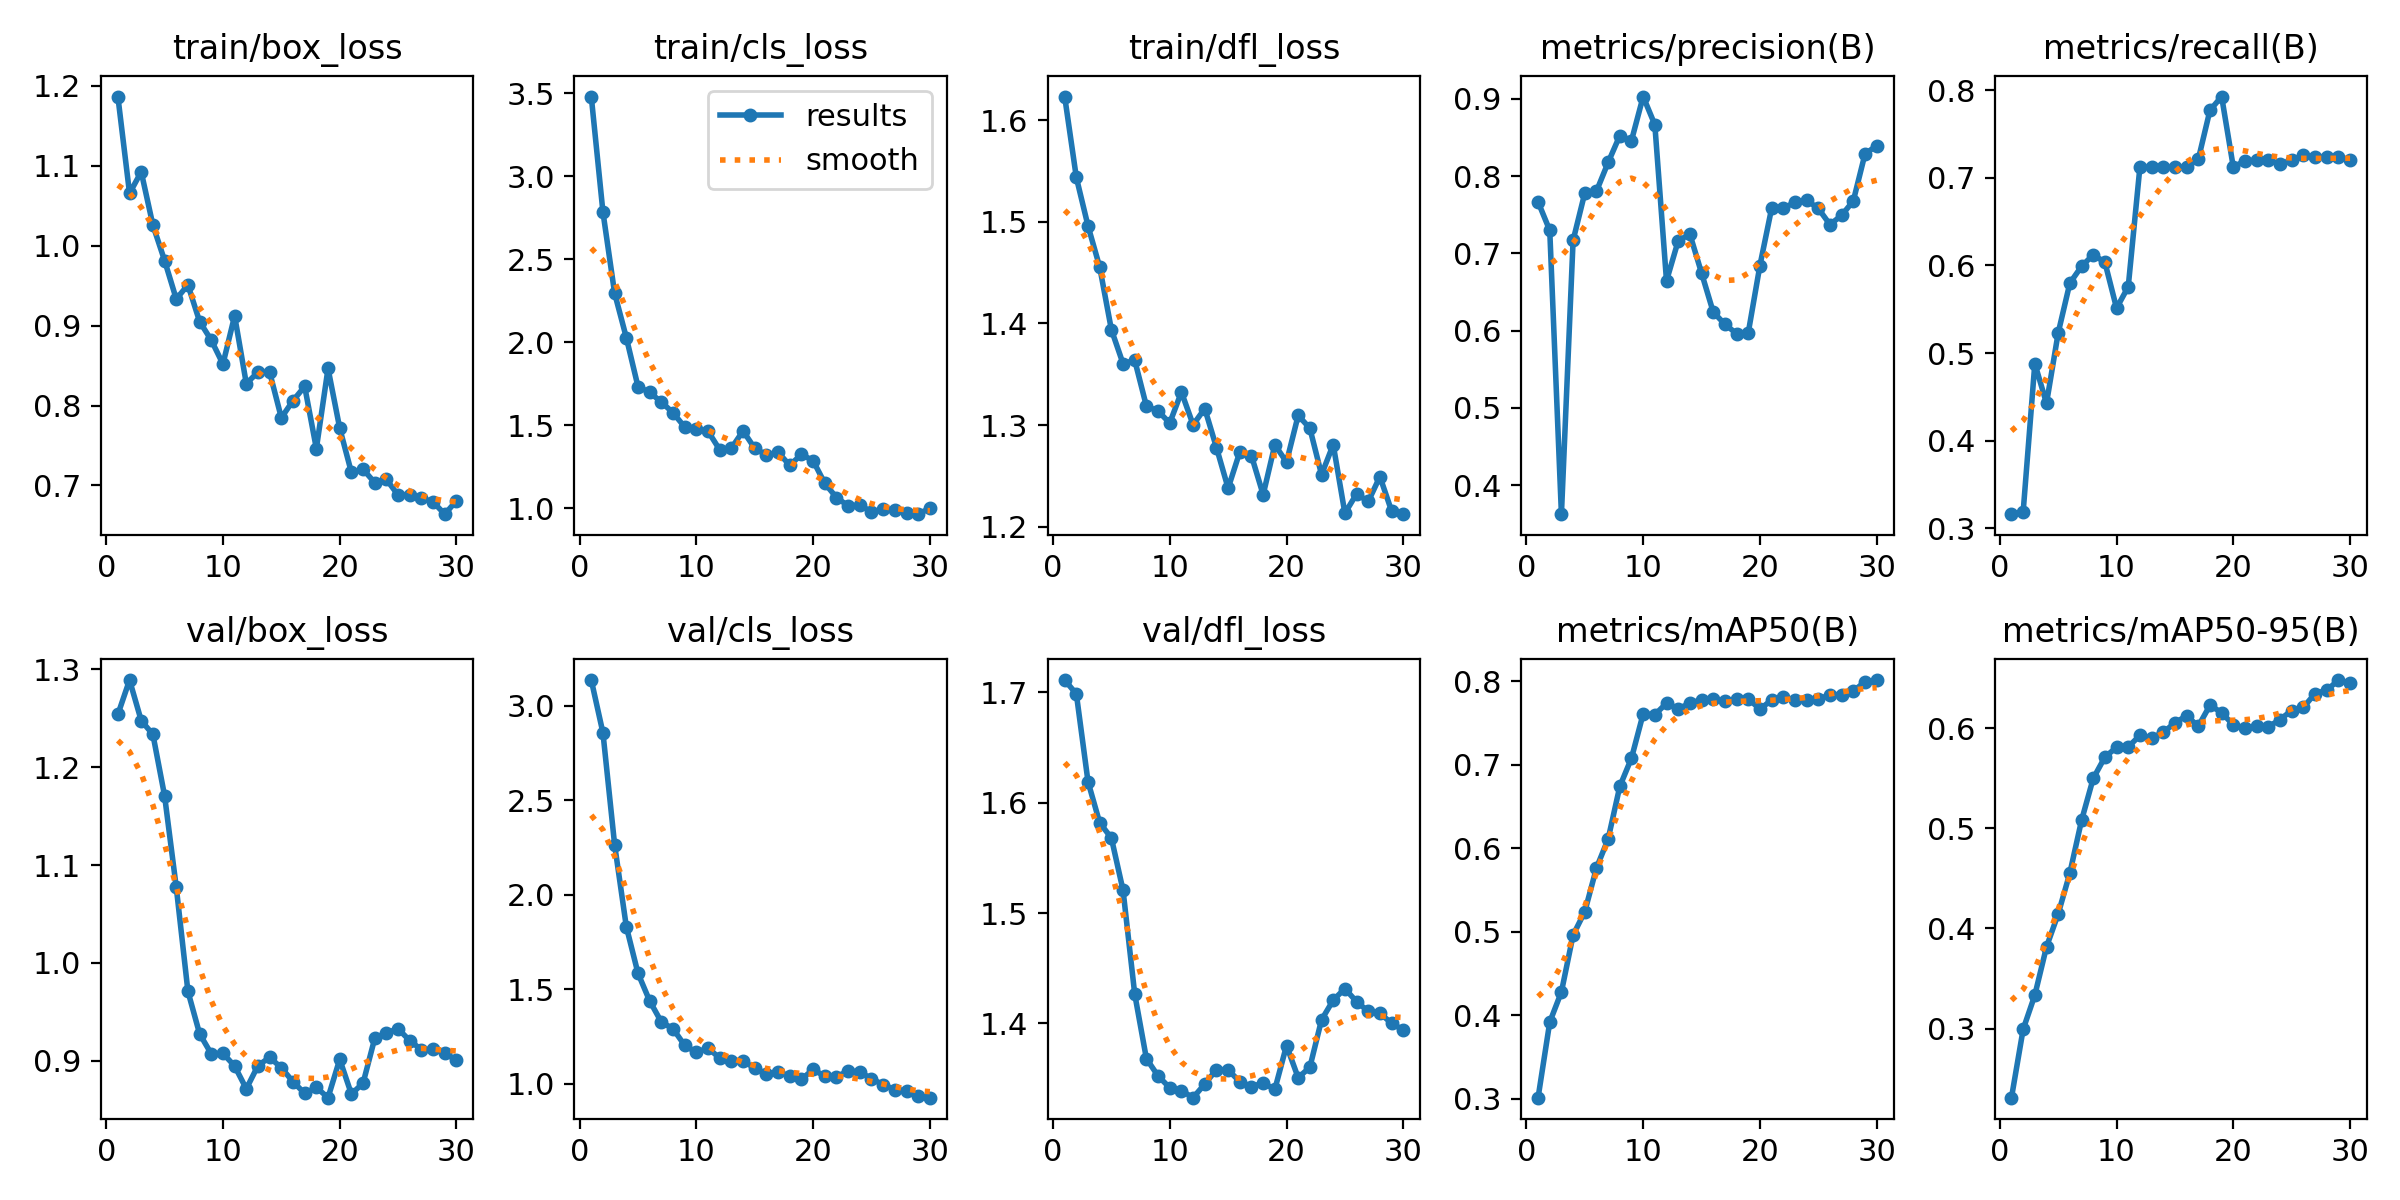

In [14]:
# Display training curves
print("📊 Training Curves")
print("-" * 40)
display(IPImage(filename=str(RESULTS_DIR / "results.png"), width=900))

📊 Confusion Matrix (Normalized)
----------------------------------------


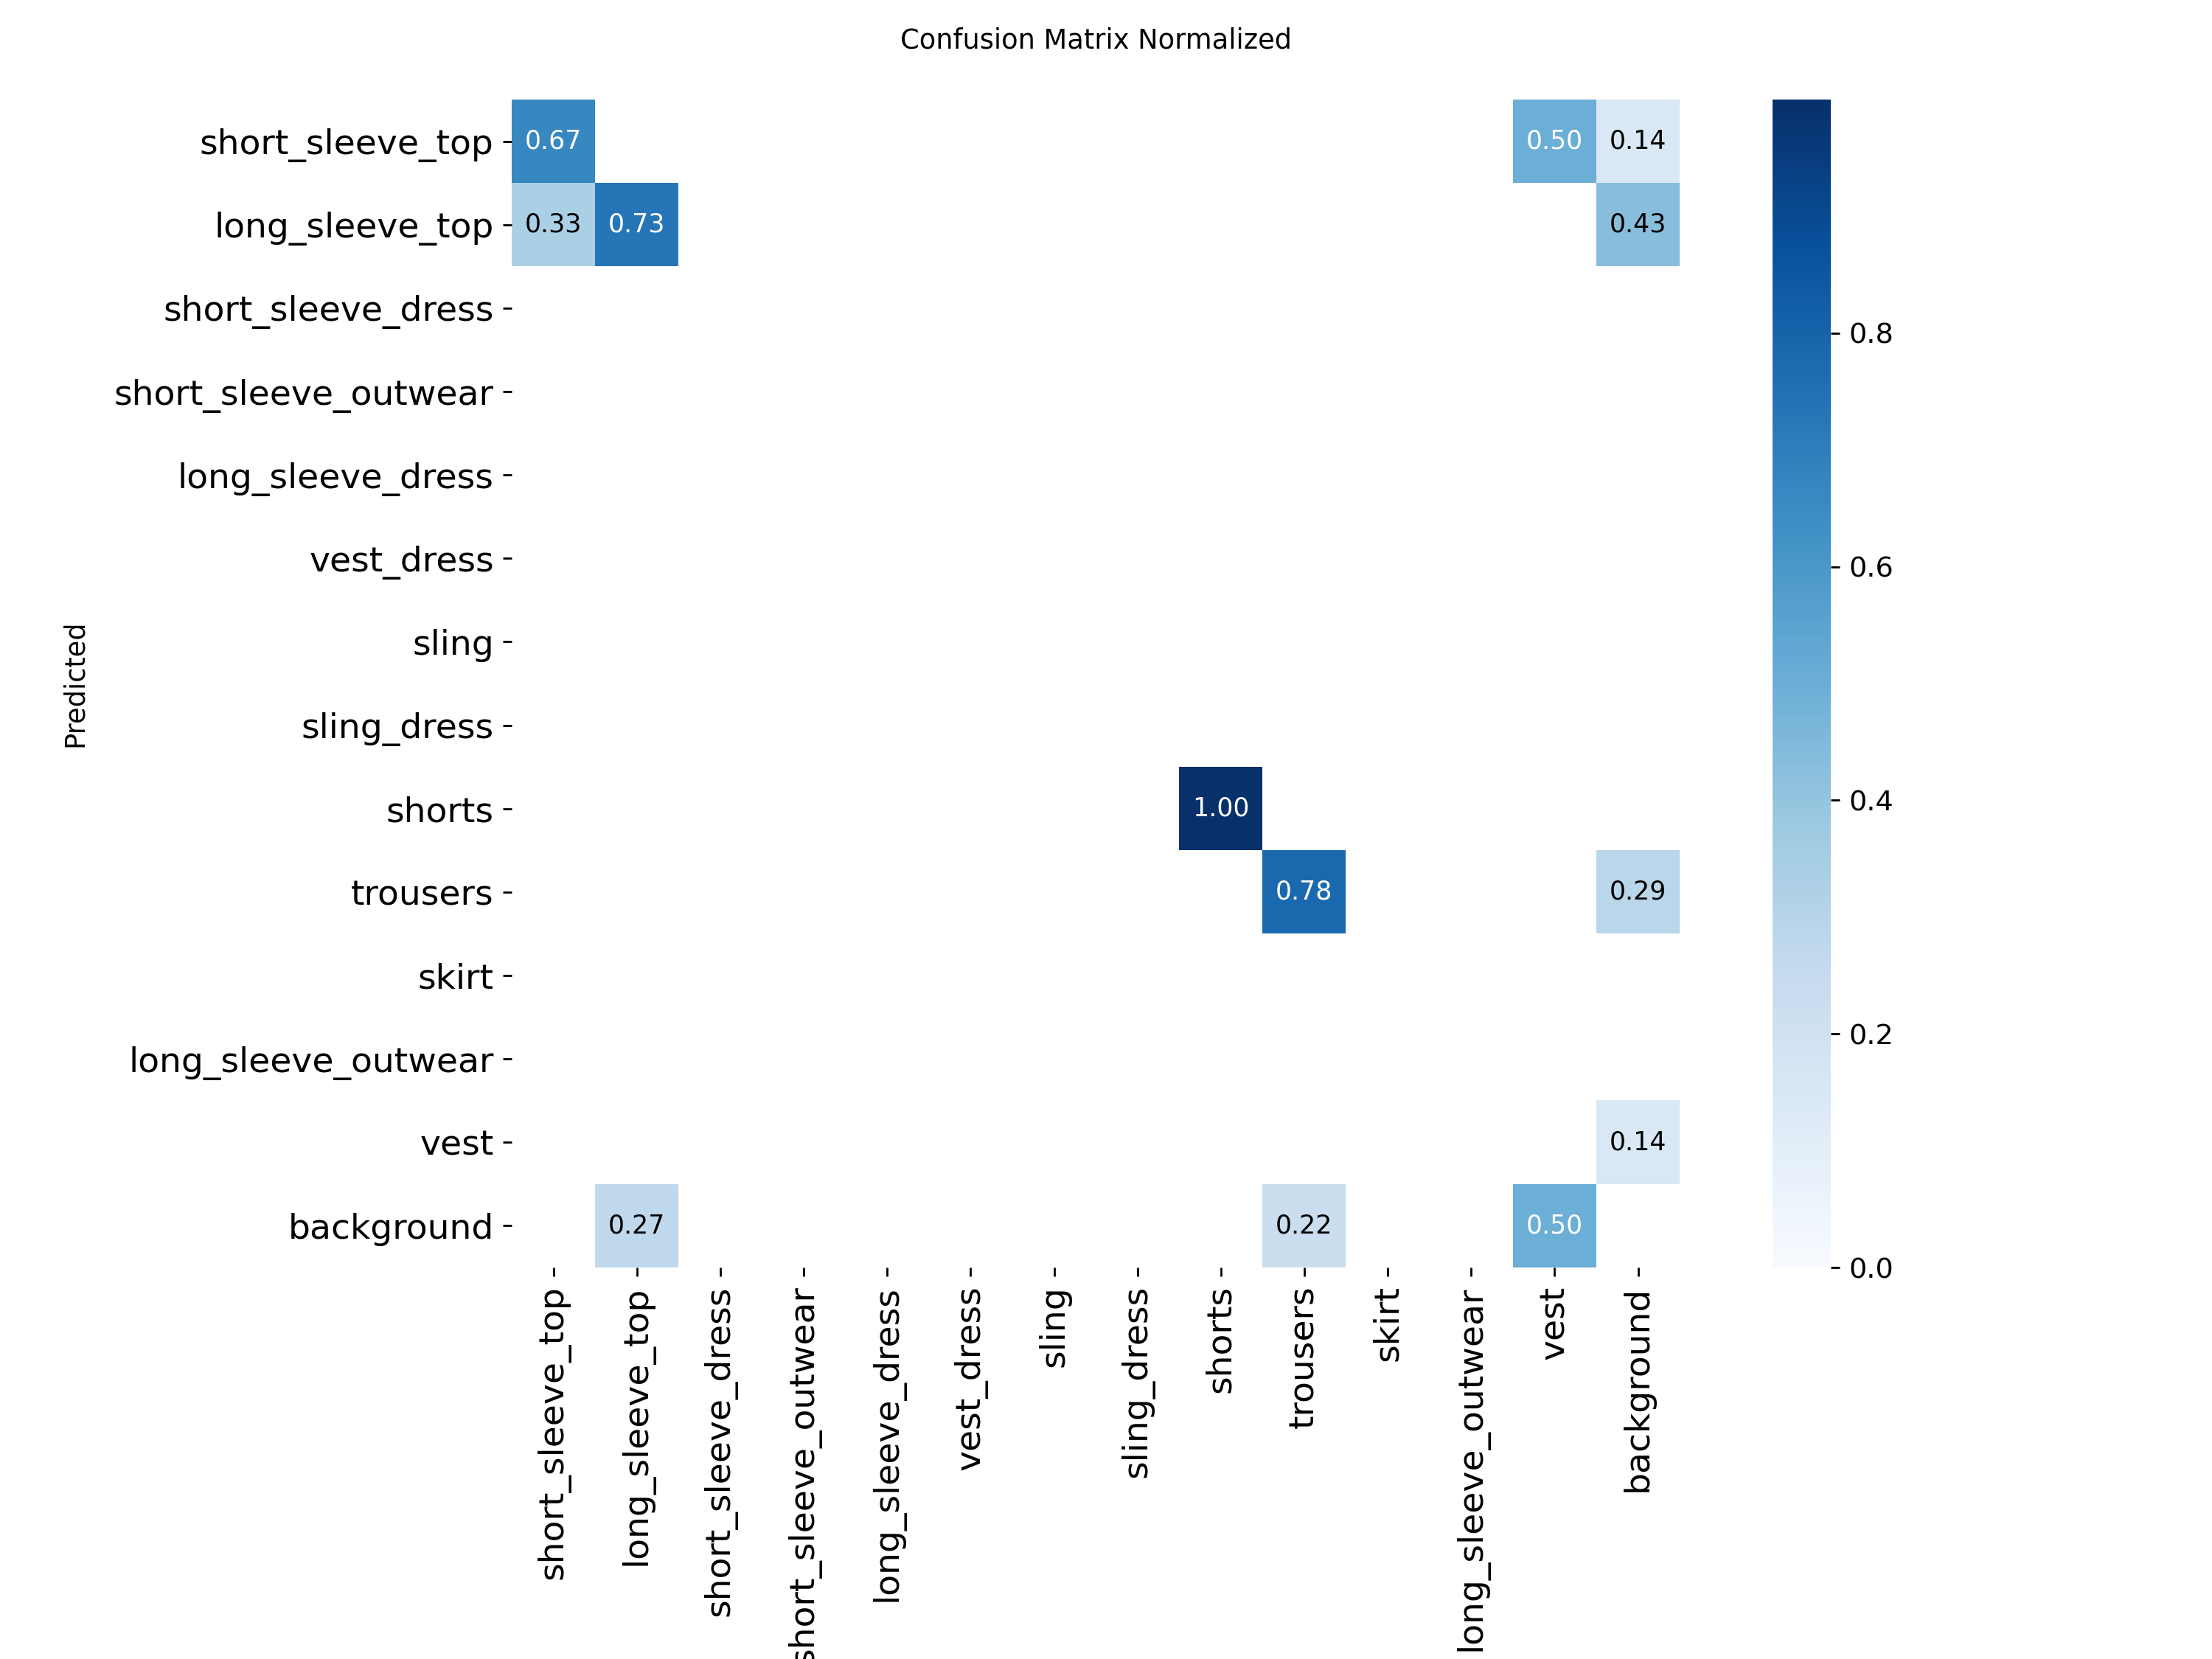

In [15]:
# Display confusion matrix
print("📊 Confusion Matrix (Normalized)")
print("-" * 40)
display(IPImage(filename=str(RESULTS_DIR / "confusion_matrix_normalized.png"), width=700))

📊 Validation Predictions
----------------------------------------
Ground Truth (left) vs Model Predictions (right)


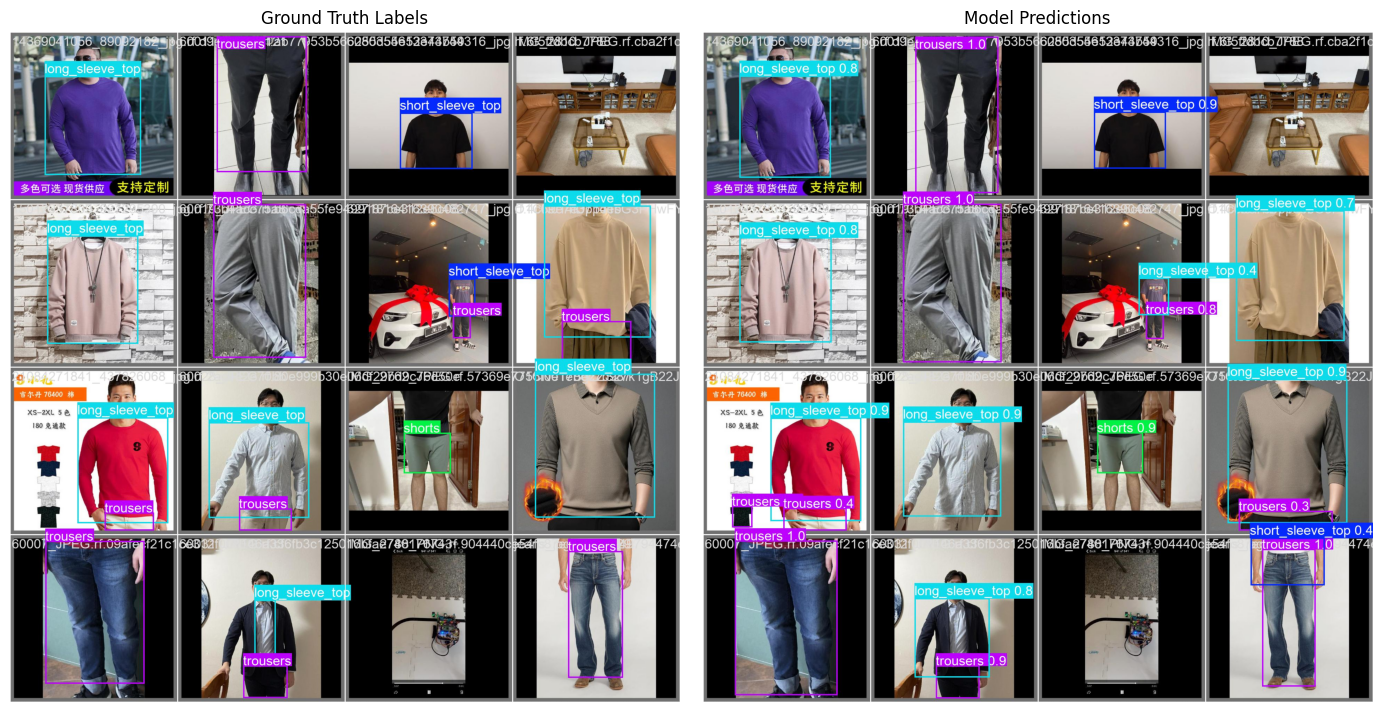

In [16]:
# Display sample predictions
print("📊 Validation Predictions")
print("-" * 40)
print("Ground Truth (left) vs Model Predictions (right)")
from IPython.display import display, Image as IPImage
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fig, axes = plt.subplots(1, 2, figsize=(14, 7))
axes[0].imshow(mpimg.imread(str(RESULTS_DIR / "val_batch0_labels.jpg")))
axes[0].set_title("Ground Truth Labels")
axes[0].axis('off')
axes[1].imshow(mpimg.imread(str(RESULTS_DIR / "val_batch0_pred.jpg")))
axes[1].set_title("Model Predictions")
axes[1].axis('off')
plt.tight_layout()
plt.show()

## ⚠️ Technical Analysis: Catastrophic Forgetting

**Observation:**
The fine-tuned model (`phase2_clothes_v6`) performs exceptionally well on the classes present in the Roboflow dataset (Tops, Shorts, Trousers, Vests) but has lost the ability to detect **Dresses** (`short_sleeve_dress`, `long_sleeve_dress`, etc.), which were present in the original DeepFashion2 dataset.

**Root Cause:**
This is a known phenomenon in transfer learning called **Catastrophic Forgetting**:
1.  **Missing Class Data:** The Roboflow v6 dataset used for fine-tuning contained **0 instances** of dress categories.
2.  **Loss Minimization:** During the 30 epochs of fine-tuning, the model calculated loss based *only* on the provided labels. Since no dresses were labeled, the model learned to treat dress features as "background" to minimize false positives.
3.  **Result:** The weights associated with dress detection were suppressed in favor of the classes that were actively reinforced (Shorts, Trousers).

### Proposed Remediation Plan for Future use (Data Mixing)
To fix this in a future iteration, we would implement **Data Mixing** to retain old knowledge while learning new edge cases:

1.  **Extract Class Subset:** 
    - Write a script to select ~500 images of *each missing class* (Dresses, Outwear) from the original DeepFashion2 dataset.
2.  **Format Conversion:** 
    - Convert their COCO-style annotations to YOLO format (using the logic from `Phase2_Fashionpedia_YOLO_Setup.ipynb`).
3.  **Dataset Merging:**
    - Copy these images/labels into the `roboflow_split_clothes/train` folders.
    - Update `data.yaml` to include all 13 class names.
4.  **Retraining:** 
    - Run the fine-tuning job again on this **Combined Dataset**. 
    - The loss function will now penalize the model if it misses a dress, forcing it to retain those weights while still learning the improved "Shorts" features.